# ACC & data prep for AnEn

* format: (site, lead_time, gen_date)
* meaning: (site/member, forecast lead time, initialization)

In [1]:
import os
import yaml
import copy
import math
import numpy as np
import pandas as pd
import xarray as xr
from collections import defaultdict

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
%matplotlib inline

In [3]:
dict_loc = {
    'Pituffik': (76.4, -68.575),
    'Fairbanks': (64.75, -147.4),
    'Guam': (13.475, 144.75),
    'Yuma_PG': (33.125, -114.125),
    'Fort_Bragg': (35.05, -79.115),
}
keys = list(dict_loc.keys())

In [4]:
base_dir = '/glade/derecho/scratch/ksha/EPRI_data/METRICS_STN/'

In [5]:
lat = [coords[0] for coords in dict_loc.values()]
lon = [coords[1] for coords in dict_loc.values()]

In [6]:
lon

[-68.575, -147.4, 144.75, -114.125, -79.115]

### AnEn Inputs

In [7]:
list_ds = []
for stn in keys:
    fn_CESM = base_dir + f'{stn}/CESM_metrics.zarr'
    ds_CESM = xr.open_zarr(fn_CESM)
    ds_CESM = ds_CESM.rename({'init_time': 'initialization', 'lead_year': 'lead_time'})
    ds_CESM = ds_CESM.drop_vars(['lat', 'lon'])
    list_ds.append(ds_CESM)
    
ds_CESM_all = xr.concat(list_ds, dim='site')
ds_CESM_all = ds_CESM_all.assign_coords({'site': keys})
ds_CESM_all = ds_CESM_all.assign_coords(lat=('lat', lat))
ds_CESM_all = ds_CESM_all.assign_coords(lon=('lon', lon))

In [8]:
ds_CESM_all = ds_CESM_all.rename({'initialization': 'gen_date'})

In [9]:
ds_CESM_all.to_netcdf(
    '/glade/derecho/scratch/ksha/EPRI_AnEn/input_AnEn_CESM_20260215.nc',
    format="NETCDF4_CLASSIC",
    engine="netcdf4",
    mode='w'
)

### ERA5 target

In [10]:
list_ds = []
for stn in keys:

    fn_ERA5 = base_dir + f'{stn}/metrics.zarr'
    ds_ERA5 = xr.open_zarr(fn_ERA5)
    ds_ERA5 = ds_ERA5.drop_vars(['latitude', 'longitude'])
    years_ext = np.arange(int(ds_ERA5["year"].min()), 2036)  # 1958..2035 inclusive
    ds_ERA5 = ds_ERA5.reindex(year=years_ext)
    
    fn_CESM = base_dir + f'{stn}/CESM_metrics.zarr'
    ds_CESM = xr.open_zarr(fn_CESM)
    ds_CESM = ds_CESM.drop_vars(['lat', 'lon'])
    
    valid_year = (ds_CESM["init_time"] + ds_CESM["lead_year"]).rename("valid_year") 
    valid_year = valid_year.transpose("lead_year", "init_time") 
    ds_target = ds_ERA5.sel(year=valid_year) 
    ds_target = ds_target.drop_vars("year") #.assign_coords(valid_year=valid_year)
    list_ds.append(ds_target)
    
ds_target_all = xr.concat(list_ds, dim='site')
ds_target_all = ds_target_all.assign_coords({'site': keys})
ds_target_all = ds_target_all.assign_coords(lat=('lat', lat))
ds_target_all = ds_target_all.assign_coords(lon=('lon', lon))

In [11]:
ds_target_all = ds_target_all.rename({'lead_year': 'lead_time', 'init_time': 'gen_date'})

In [12]:
# NaN to -9999
fill = -9999.0

encoding = {}
for v in ds_target_all.data_vars:
    encoding[v] = {"_FillValue": fill}

ds_target_all.to_netcdf(
    '/glade/derecho/scratch/ksha/EPRI_AnEn/input_AnEn_ERA5_20260215.nc',
    format="NETCDF4_CLASSIC",
    engine="netcdf4",
    encoding=encoding,
    mode='w'
)

### Check timeseries 

In [13]:
fn_input = '/glade/derecho/scratch/ksha/EPRI_AnEn/input_AnEn_CESM_20260215.nc'
fn_target = '/glade/derecho/scratch/ksha/EPRI_AnEn/input_AnEn_ERA5_20260215.nc'

ds_input = xr.open_dataset(fn_input)
ds_target = xr.open_dataset(fn_target)

In [14]:
T2_mean_CESM = ds_input['TREFHT_mean_default'].isel(site=2).values
T2_mean_ERA5 = ds_target['TREFHT_mean_default'].isel(site=2).values

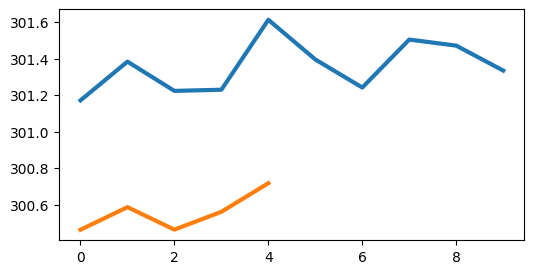

In [15]:
plt.figure(figsize=(6, 3))
plt.plot(T2_mean_CESM[:, -1], lw=3)
plt.plot(T2_mean_ERA5[:, -1], lw=3)

### ACC

In [16]:
fn_input = '/glade/derecho/scratch/ksha/EPRI_AnEn/input_AnEn_CESM_20260215.nc'
fn_target = '/glade/derecho/scratch/ksha/EPRI_AnEn/input_AnEn_ERA5_20260215.nc'

ds_input = xr.open_dataset(fn_input)
ds_target = xr.open_dataset(fn_target)

In [17]:
list_ACC_lead = []

varnames = list(ds_ERA5.keys())

for i_lead in range(10):
    list_ACC_var = []
    for varname in varnames:
        input_ = ds_input[varname].isel(lead_time=i_lead)
        target_ = ds_target[varname].isel(lead_time=i_lead)

        mask = target_.notnull()
        input_clean  = input_.where(mask, drop=True)
        target_clean = target_.where(mask, drop=True)

        if len(target_clean['gen_date']) > 10:
            list_ACC_var.append(
                xr.corr(
                    input_clean, 
                    target_clean, 
                    dim="gen_date"
                )
            )
    ds_ACC_lead = xr.merge(list_ACC_var)
    list_ACC_lead.append(ds_ACC_lead)

ds_ACC = xr.concat(list_ACC_lead, dim='lead_time')

In [18]:
# ds_ACC.to_zarr(base_dir+'ACC_all.zarr', mode='w')

In [19]:
ds = xr.open_zarr(base_dir+'ACC_all.zarr')

In [20]:
lead_dim="lead_time"
site_dim="site"
variants=("anom", "default", "detrend")
ncols=3
sharey=True

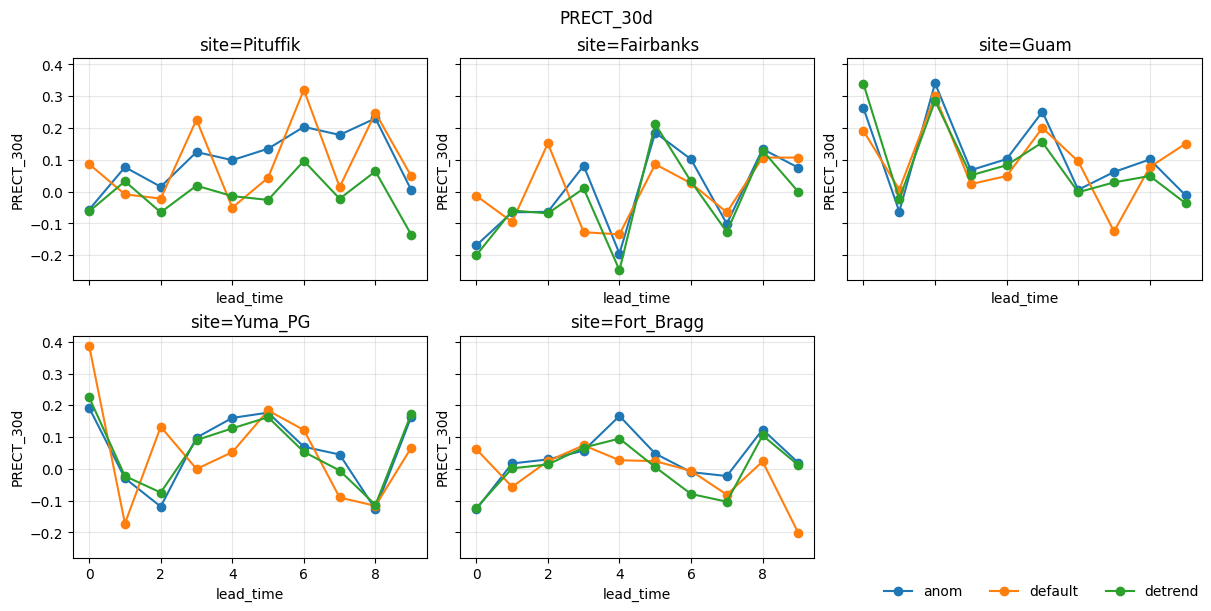

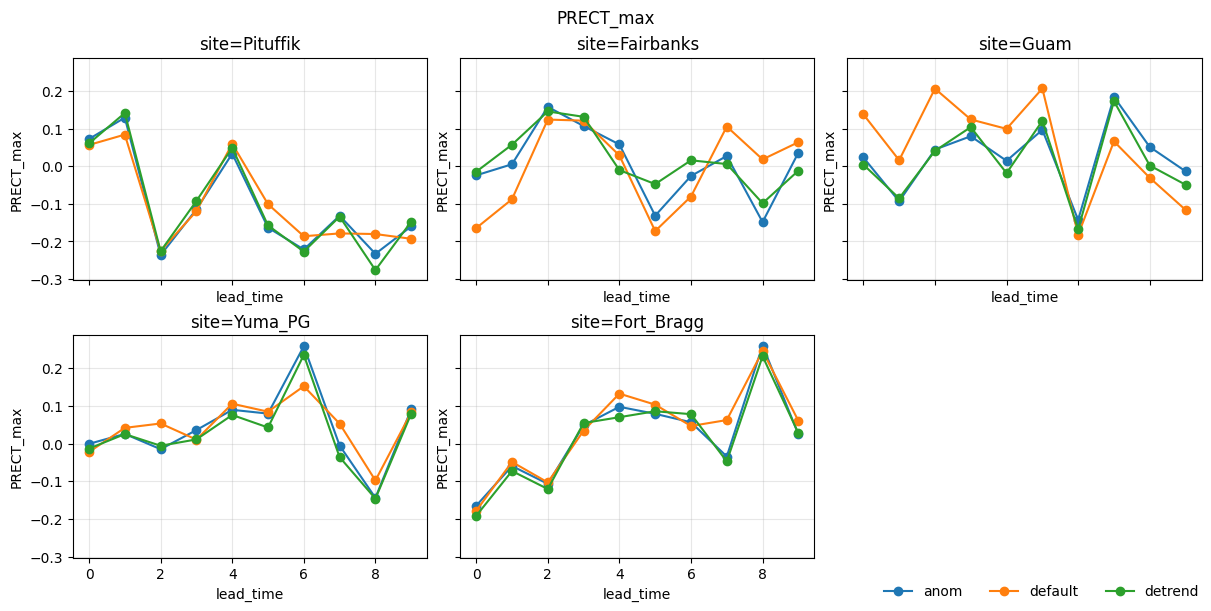

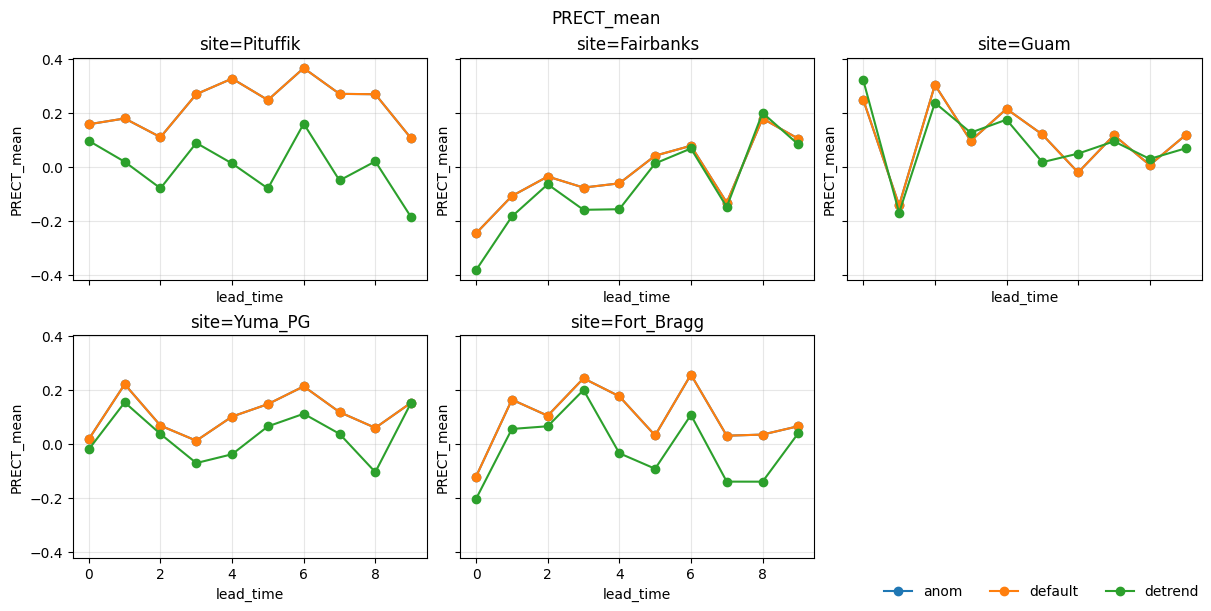

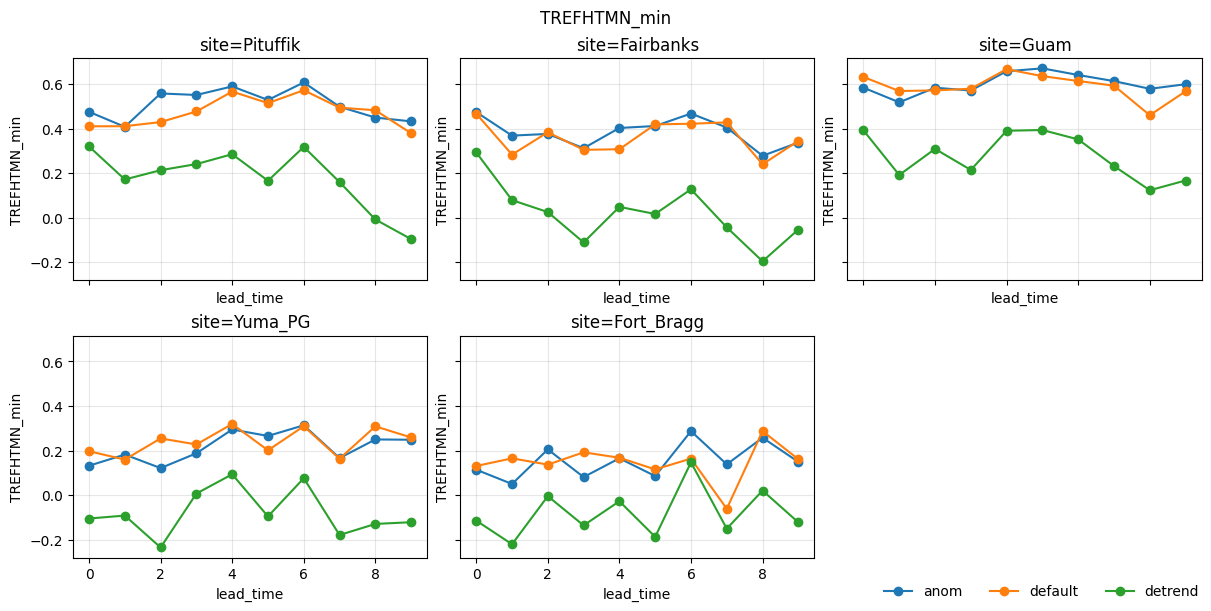

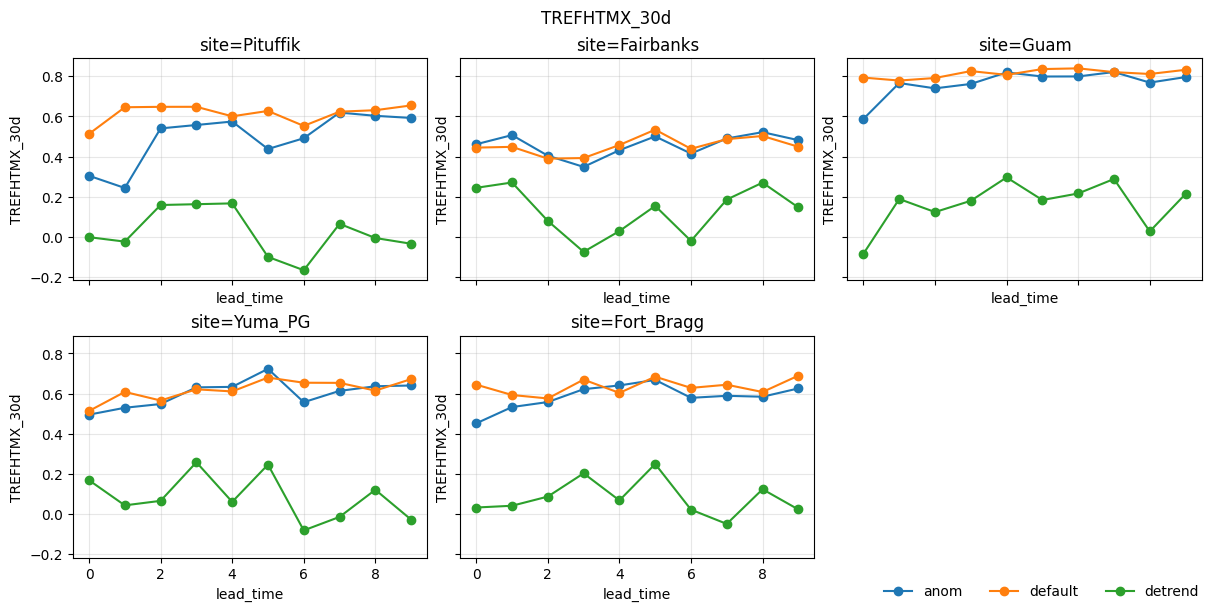

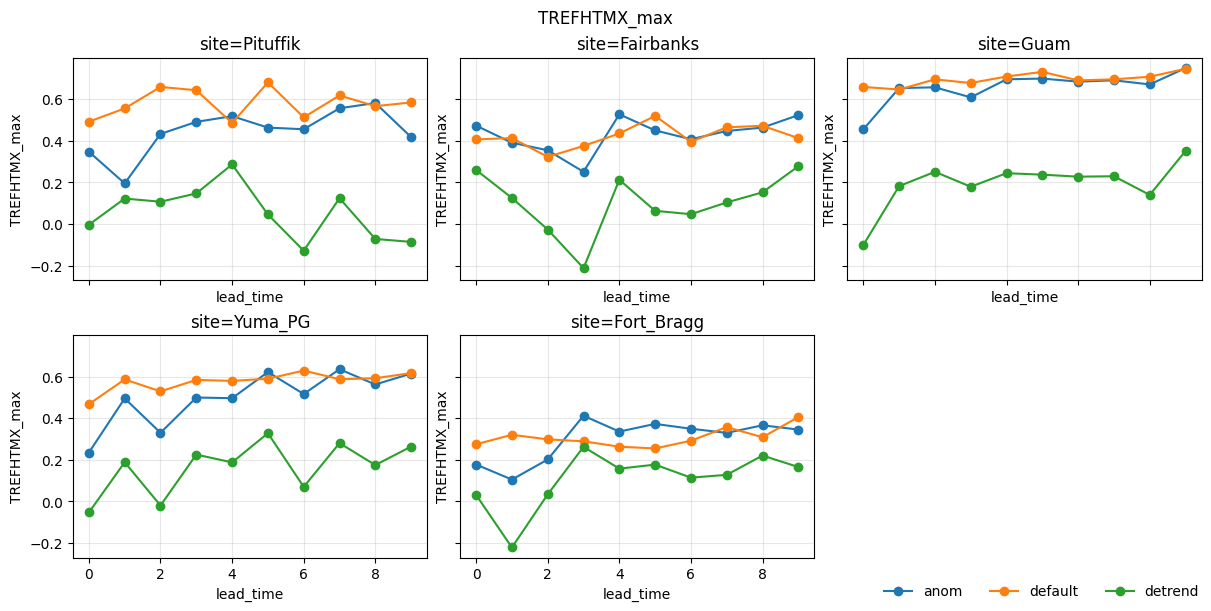

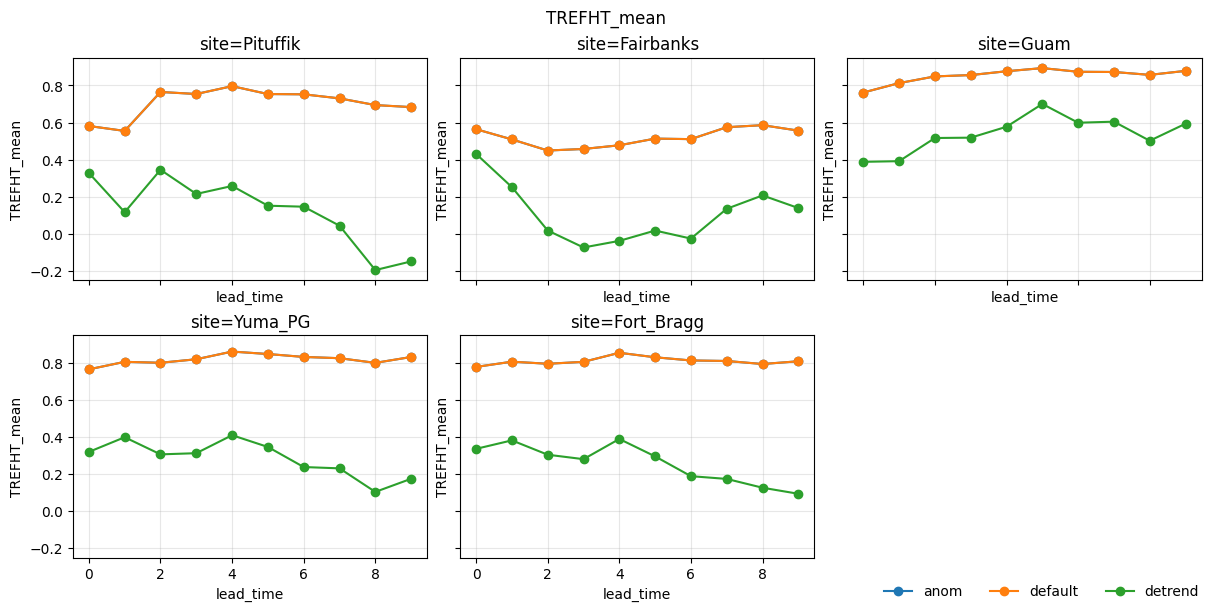

In [21]:
# for dim in (lead_dim, site_dim):
#     if dim not in ds.dims:
#         raise ValueError(f"{dim!r} not in ds.dims. Found: {list(ds.dims)}")

# --- build groups: base -> {variant: varname} ---
groups = defaultdict(dict)
for v in ds.data_vars:
    if "_" not in v:
        continue
    base, var_variant = v.rsplit("_", 1)  # split on last underscore
    if var_variant in variants:
        groups[base][var_variant] = v


xvals = ds[lead_dim].values if lead_dim in ds.coords else np.arange(ds.sizes[lead_dim])
site_labels = ds[site_dim].values if site_dim in ds.coords else np.arange(ds.sizes[site_dim])
n_sites = ds.sizes[site_dim]
nrows = math.ceil(n_sites / ncols)

for base in sorted(groups):
    
    members = groups[base]  # dict: variant -> varname

    fig, axs = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        sharex=True,
        sharey=sharey,
        figsize=(4 * ncols, 3 * nrows),
        constrained_layout=True,
    )
    axs = np.atleast_1d(axs).ravel()

    for i in range(n_sites):
        ax = axs[i]
        site_val = site_labels[i]

        # select this site (sel if coord exists, else isel)
        if site_dim in ds.coords:
            selector = {site_dim: site_val}
            select_fn = "sel"
        else:
            selector = {site_dim: i}
            select_fn = "isel"

        # plot variants in a consistent order
        for var_variant in variants:
            if var_variant not in members:
                continue
            vname = members[var_variant]
            da = getattr(ds[vname], select_fn)(selector)  # 1D over lead_time
            ax.plot(xvals, da.values, marker="o", label=var_variant)

        ax.set_title(f"{site_dim}={site_val}")
        ax.set_xlabel(lead_dim)
        ax.set_ylabel(base)
        ax.grid(True, alpha=0.3)

    # turn off unused axes
    for j in range(n_sites, len(axs)):
        axs[j].axis("off")

    # one legend for the whole figure
    handles, labels = axs[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, ncol=3, loc='lower right', frameon=False)

    fig.suptitle(base)